In [15]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import pandas as pd
import keras_tuner
import seaborn as sns
import itertools
import os
import tensorflowjs as tfjs

from tensorflow import keras
from tensorflow.keras.optimizers.legacy import Adam
from tensorflow.keras import initializers
from keras import regularizers
from keras.layers import Dropout, BatchNormalization
from keras_tuner.tuners import RandomSearch
from PIL import Image
from ast import literal_eval
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
from sklearn import preprocessing
from sklearn import metrics
from sklearn.metrics import classification_report

**Carga datos Train-Test-Valid**



In [2]:
dataset = pd.read_csv("data/birds.csv")
train = dataset.loc[dataset['data set'] == "train"].head(1100).reset_index()
test = dataset.loc[dataset['data set'] == "test"].reset_index()
valid = dataset.loc[dataset['data set'] == "valid"].reset_index()

In [3]:
train = train.drop(columns=['index'])
test = test.drop(columns=['index'])
valid = valid.drop(columns=['index'])

In [7]:
test.tail()

,class id,filepaths,labels,data set,scientific name
2620,524.0,test/BLACK BREASTED PUFFBIRD/3.jpg,BLACK BREASTED PUFFBIRD,test,NOTHARCHUS PECTORALIS
2621,524.0,test/BLACK BREASTED PUFFBIRD/4.jpg,BLACK BREASTED PUFFBIRD,test,NOTHARCHUS PECTORALIS
2622,524.0,test/BLACK BREASTED PUFFBIRD/1.jpg,BLACK BREASTED PUFFBIRD,test,NOTHARCHUS PECTORALIS
2623,524.0,test/BLACK BREASTED PUFFBIRD/2.jpg,BLACK BREASTED PUFFBIRD,test,NOTHARCHUS PECTORALIS
2624,524.0,test/BLACK BREASTED PUFFBIRD/5.jpg,BLACK BREASTED PUFFBIRD,test,NOTHARCHUS PECTORALIS


In [5]:
train["labels"].value_counts()

ABBOTTS BOOBY                 180
ABYSSINIAN GROUND HORNBILL    179
ABBOTTS BABBLER               163
AFRICAN EMERALD CUCKOO        154
AFRICAN OYSTER CATCHER        152
AFRICAN FIREFINCH             137
AFRICAN CROWNED CRANE         135
Name: labels, dtype: int64

Los datos no están muy balanceados, ya que hay especies con más fotos que otras.

**One Hot Encoding de las variables objetivo**

In [4]:
labels = ["ABBOTTS BOOBY", "ABYSSINIAN GROUND HORNBILL", "ABBOTTS BABBLER", "AFRICAN EMERALD CUCKOO", "AFRICAN OYSTER CATCHER", "AFRICAN FIREFINCH", "AFRICAN CROWNED CRANE"]

In [5]:
X_train = []
Y_train = []
for i in train.index:
    label = train["labels"][i]
    path = "data/" + train["filepaths"][i]
    image = Image.open(path)
    array = np.array(image)
    X_train.append(array)
    Y_train.append(label)
X_train = np.array(X_train)/255
Y_train = np.array(Y_train)

In [6]:
X_test = []
Y_test = []
for i in range(35):
    label = test["labels"][i]
    path = "data/" + test["filepaths"][i]
    image = Image.open(path)
    array = np.array(image)
    X_test.append(array)
    Y_test.append(label)
X_test = np.array(X_test)/255
Y_test = np.array(Y_test)

In [7]:
X_valid = []
Y_valid = []
for i in range(35):
    label = valid["labels"][i]
    path = "data/" + valid["filepaths"][i]
    image = Image.open(path)
    array = np.array(image)
    X_valid.append(array)
    Y_valid.append(label)
X_valid = np.array(X_valid)/255
Y_valid = np.array(Y_valid)

In [10]:
X_train.shape

(1100, 224, 224, 3)

In [11]:
X_test.shape

(35, 224, 224, 3)

In [12]:
X_valid.shape

(35, 224, 224, 3)

In [11]:
enc = preprocessing.OrdinalEncoder(categories=[labels])
Y_train = enc.fit_transform(Y_train.reshape(-1, 1)).ravel()
Y_test = enc.fit_transform(Y_test.reshape(-1, 1)).ravel()
Y_valid = enc.fit_transform(Y_valid.reshape(-1, 1)).ravel()

**Creación del modelo CNN**

In [12]:
datagen = ImageDataGenerator(
    rotation_range=10, # Degree range for random rotations.
    zoom_range=0.1, # Range for random zoom
    width_shift_range=0.1, # fraction of total width (traslation)
    height_shift_range=0.1, # fraction of total height (traslation)
    horizontal_flip=False, # Randomly flip inputs horizontally.
    vertical_flip=False # Randomly flip inputs vertically.
)
datagen.fit(X_train)

In [15]:
model = Sequential()
input_shape=(224, 224, 3)

# Convolution layer 1
model.add(Conv2D(filters=120, kernel_size=(3,3), strides=(1,1),padding='same',activation='relu',input_shape=input_shape))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer 2
model.add(Conv2D(filters=100, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer 3
model.add(Conv2D(filters=80, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))
# Convolution layer 4
model.add(Conv2D(filters=60, kernel_size=(3,3),strides=(1,1),padding='same',activation='relu'))
model.add(MaxPool2D(pool_size=(2,2)))

# Flatten Layers
model.add(Flatten())

# Dense layers
model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.3))
model.add(Dense(units=1000,activation='relu'))
model.add(Dropout(0.2))
model.add(Dense(units=len(labels) ,activation='softmax'))

In [16]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience=3, verbose=1, factor=0.5, min_lr=0.00001)

In [18]:
history = model.fit(
    datagen.flow(X_train, Y_train, batch_size=64),
    epochs=20,
    validation_data=(X_valid, Y_valid),
    verbose=2,
    steps_per_epoch=X_train.shape[0] // 64,
    callbacks=[learning_rate_reduction]
)

Epoch 1/20
17/17 - 46s - loss: 1.9458 - accuracy: 0.1400 - val_loss: 1.9427 - val_accuracy: 0.1429 - lr: 0.0100 - 46s/epoch - 3s/step
Epoch 2/20
17/17 - 40s - loss: 1.9439 - accuracy: 0.1602 - val_loss: 1.9411 - val_accuracy: 0.1429 - lr: 0.0100 - 40s/epoch - 2s/step
Epoch 3/20
17/17 - 40s - loss: 1.9410 - accuracy: 0.1708 - val_loss: 1.9394 - val_accuracy: 0.1714 - lr: 0.0100 - 40s/epoch - 2s/step
Epoch 4/20
17/17 - 40s - loss: 1.9391 - accuracy: 0.1641 - val_loss: 1.9382 - val_accuracy: 0.1714 - lr: 0.0100 - 40s/epoch - 2s/step
Epoch 5/20
17/17 - 40s - loss: 1.9349 - accuracy: 0.1737 - val_loss: 1.9354 - val_accuracy: 0.1429 - lr: 0.0100 - 40s/epoch - 2s/step
Epoch 6/20

Epoch 6: ReduceLROnPlateau reducing learning rate to 0.004999999888241291.
17/17 - 40s - loss: 1.9302 - accuracy: 0.2008 - val_loss: 1.9325 - val_accuracy: 0.1429 - lr: 0.0100 - 40s/epoch - 2s/step
Epoch 7/20
17/17 - 40s - loss: 1.9274 - accuracy: 0.2066 - val_loss: 1.9301 - val_accuracy: 0.1714 - lr: 0.0050 - 40s/ep

**Evaluación del modelo**

In [19]:
loss, accuracy = model.evaluate(X_train, Y_train)
print("Final training loss: {:.8f}".format(loss))
print("Final training accuracy: {:.4%}".format(accuracy))

35/35 [==============================] - 10s 288ms/step - loss: 1.8931 - accuracy: 0.2691
Final training loss: 1.89306462
Final training accuracy: 26.9091%


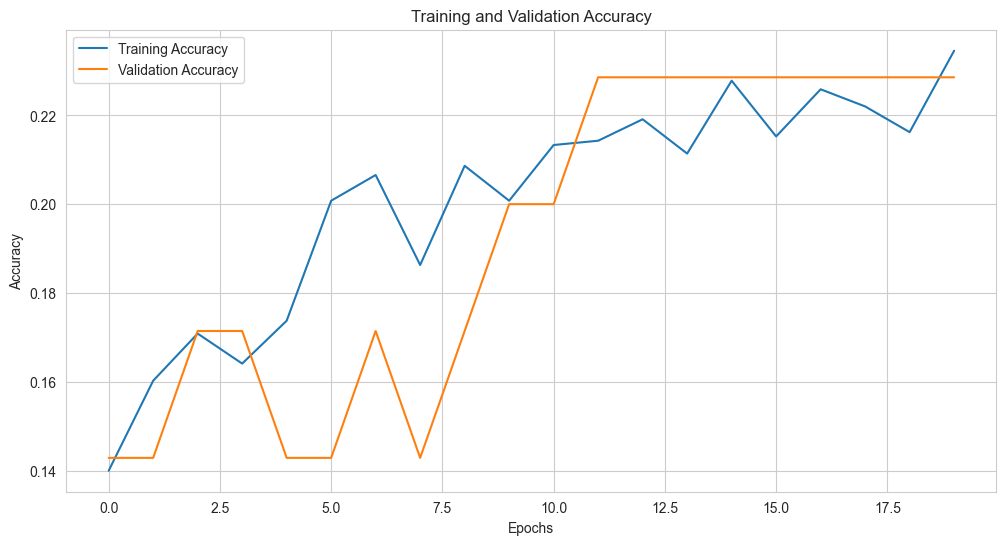

In [20]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

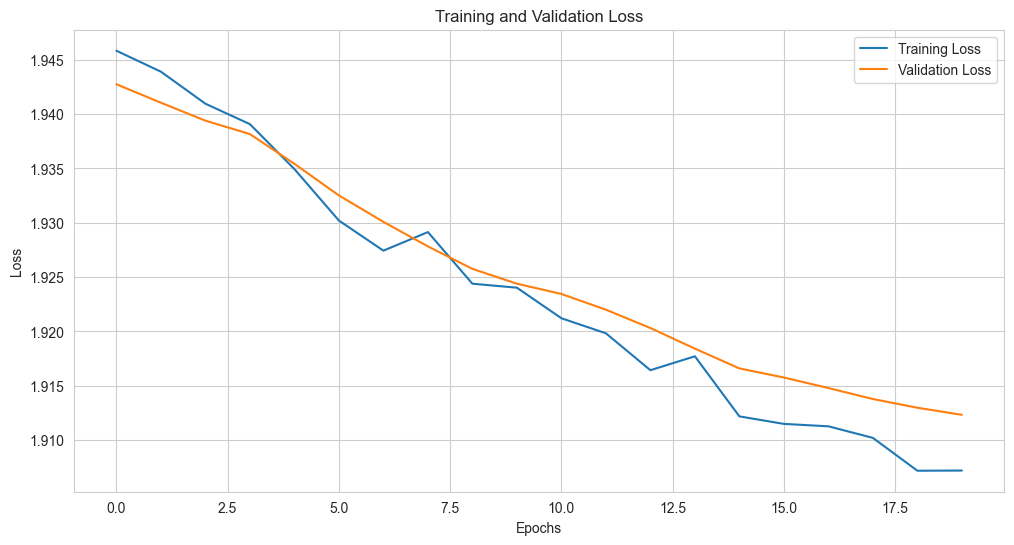

In [21]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

El modelo resultó ser bastante malo, por lo que buscaremos los mejores hiperparámetros posibles.

In [65]:
def build_model(hp):
    initializer = initializers.HeNormal(seed=20)
    model = Sequential()    
    regu = hp.Choice('l1_reg', [0.001, 0.0001])
    input_shape=(224, 224, 3)
    
    #Conv layer loop
    for i in range(4):
        nodes = hp.Choice(f'nodes_{i+1}', [32, 64, 128, 256, 512])
        model.add(Conv2D(nodes, (3, 3), activation='relu', input_shape=input_shape, kernel_initializer=initializer, kernel_regularizer=regularizers.l1(regu)))
        model.add(MaxPooling2D(pool_size=(2, 2)))
        model.add(BatchNormalization(momentum=hp.Float('momentum', min_value=0.8, max_value=0.9, step=0.05), epsilon=0.001))
    model.add(Flatten())
    
    #Fully Connected layers
    for i in range(4):
        units = hp.Choice(f'units_{i+1}', [32, 64, 128, 256, 512])
        model.add(Dense(units, activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l1(regu)))
        model.add(BatchNormalization(momentum=hp.Float('momentum', min_value=0.8, max_value=0.95, step=0.05), epsilon=0.001))
     
    model.add(Dense(units=len(labels), activation='softmax', kernel_initializer=initializer))

    opt = Adam(learning_rate=hp.Choice('learning_rate', [0.001, 0.0001]))
    model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])
    return model

In [15]:
train_pre = ImageDataGenerator(rescale=1./255)
test_pre = ImageDataGenerator(rescale = 1./255)
valid_pre = ImageDataGenerator(rescale = 1./255)

In [16]:
batch_size = 64
train_main = train_pre.flow(X_train, Y_train, batch_size=batch_size)
valid_main = valid_pre.flow(X_valid, Y_valid, batch_size=batch_size)
test_main = test_pre.flow(X_test, Y_test, batch_size=batch_size)

In [66]:
#Using a bayesian optimizer
tuner = keras_tuner.BayesianOptimization(
    build_model,
    objective=keras_tuner.Objective("val_loss", direction="min"),
    max_trials=70, 
    num_initial_points=35,  
    overwrite=True  
)
tuner.search(train_main, epochs=5, validation_data=(valid_main))

Trial 50 Complete [00h 06m 29s]
val_loss: 5.541567802429199

Best val_loss So Far: 1.759716272354126
Total elapsed time: 10h 31m 44s

Search: Running Trial #51

Value             |Best Value So Far |Hyperparameter
0.0001            |0.0001            |l1_reg
512               |32                |nodes_1
0.85              |0.85              |momentum
512               |32                |nodes_2
512               |128               |nodes_3
32                |32                |nodes_4
256               |64                |units_1
512               |32                |units_2
512               |64                |units_3
32                |32                |units_4
0.001             |0.001             |learning_rate

Epoch 1/5


KeyboardInterrupt: 

In [67]:
best_hp = tuner.get_best_hyperparameters()[0]
print("Best Hyperparameters:")
for param, value in best_hp.values.items():
    print(f"{param}: {value}")

# Print the best model summary
best_model = tuner.get_best_models()[0]

Best Hyperparameters:
l1_reg: 0.0001
nodes_1: 32
momentum: 0.8500000000000001
nodes_2: 32
nodes_3: 128
nodes_4: 32
units_1: 64
units_2: 32
units_3: 64
units_4: 32
learning_rate: 0.001


In [9]:
initializer = initializers.HeNormal(seed=20)
model1 = Sequential()
nodes = [32, 32, 128, 32]
units = [64, 32, 64, 32]
learning_rate = 0.001
momentum = 0.8500000000000001
l1_reg = 0.0001
    
for i in range(4):        
    
    model1.add(Conv2D(nodes[i], (3, 3), activation='relu', kernel_initializer=initializer, kernel_regularizer=regularizers.l1(l1_reg)))
    model1.add(MaxPooling2D(pool_size=(2, 2)))
    model1.add(BatchNormalization(momentum=momentum, epsilon=0.001))
    
model1.add(Flatten())
    
for i in range(4):
    model1.add(Dense(units=units[i],activation='relu',kernel_initializer=initializer,kernel_regularizer=regularizers.l1(l1_reg)))
    model1.add(BatchNormalization(momentum=momentum, epsilon=0.001))
        
model1.add(Dense(units=len(labels), activation='softmax', kernel_initializer=initializer))

opt = Adam(learning_rate=learning_rate)
model1.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics=['accuracy'])

In [13]:
history1 = model1.fit(
    datagen.flow(X_train, Y_train, batch_size=64),
    epochs=20,
    validation_data=(X_valid, Y_valid),
    steps_per_epoch=X_train.shape[0] // 64,
)
# Evaluate the model
loss, accuracy = model1.evaluate(X_train, Y_train)
print("Final training loss: {:.8f}".format(loss))
print("Final training accuracy: {:.4%}".format(accuracy))

Epoch 1/20
17/17 [==============================] - 11s 599ms/step - loss: 2.9913 - accuracy: 0.3137 - val_loss: 3.1561 - val_accuracy: 0.3143
Epoch 2/20
17/17 [==============================] - 9s 539ms/step - loss: 2.4194 - accuracy: 0.5338 - val_loss: 2.4262 - val_accuracy: 0.5429
Epoch 3/20
17/17 [==============================] - 9s 536ms/step - loss: 2.1476 - accuracy: 0.6458 - val_loss: 2.0721 - val_accuracy: 0.6286
Epoch 4/20
17/17 [==============================] - 10s 543ms/step - loss: 1.9883 - accuracy: 0.6969 - val_loss: 2.0063 - val_accuracy: 0.6857
Epoch 5/20
17/17 [==============================] - 10s 543ms/step - loss: 1.8438 - accuracy: 0.7616 - val_loss: 1.8975 - val_accuracy: 0.7143
Epoch 6/20
17/17 [==============================] - 10s 544ms/step - loss: 1.7481 - accuracy: 0.7790 - val_loss: 1.8178 - val_accuracy: 0.7429
Epoch 7/20
17/17 [==============================] - 10s 543ms/step - loss: 1.6814 - accuracy: 0.8050 - val_loss: 1.9635 - val_accuracy: 0.6571
E

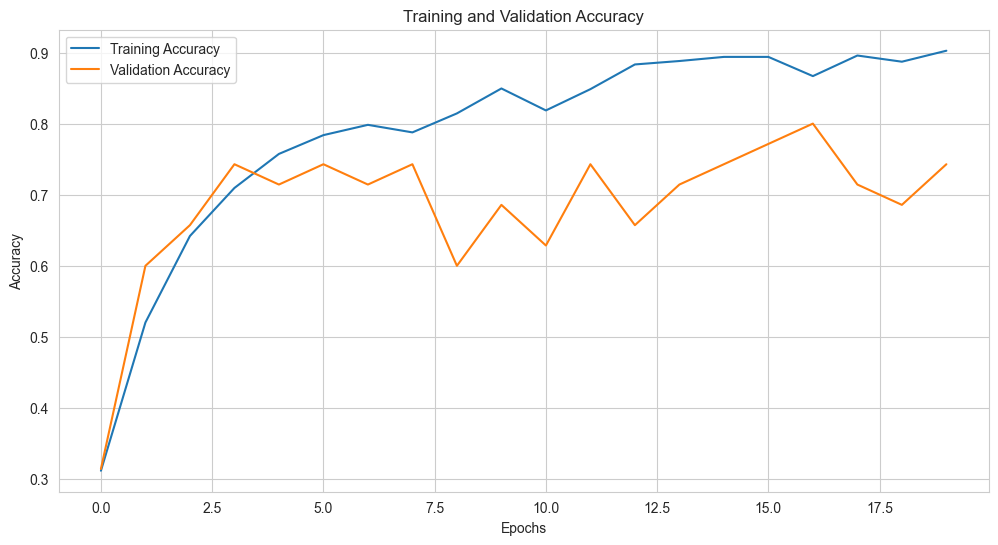

In [22]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history1.history['accuracy'], label='Training Accuracy')
plt.plot(history1.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

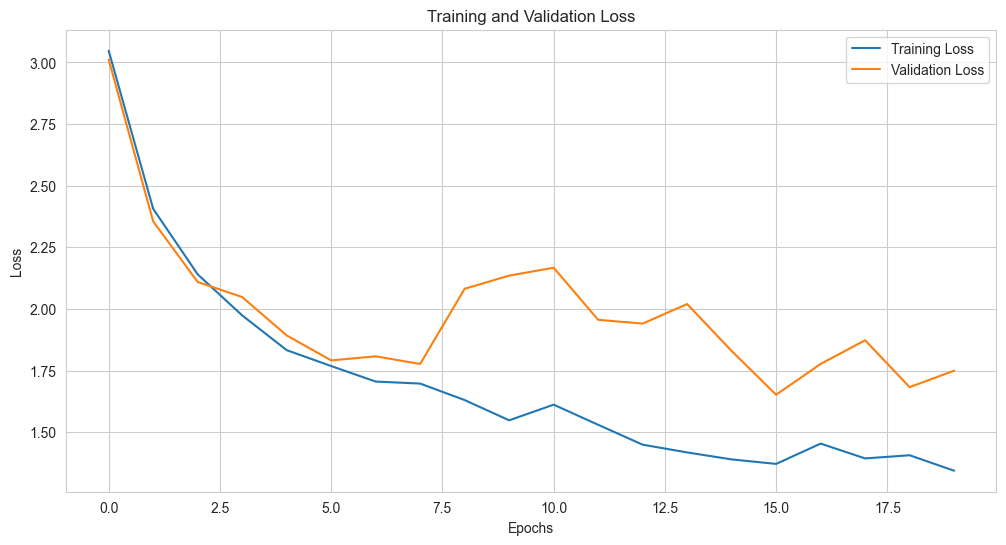

In [23]:
plt.figure(figsize=(12, 6))
sns.set_style("whitegrid")
plt.plot(history1.history['loss'], label='Training Loss')
plt.plot(history1.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [56]:
def reverse_encoding(array):
    list = []
    for a in array:
        label = np.argmax(a)
        list.append(label)
    return np.array(list)
    

In [57]:
Y_pred = model1.predict(X_test)
Y_pred = reverse_encoding(Y_pred)
print(classification_report(Y_test, Y_pred))

2/2 [==============================] - 0s 12ms/step
              precision    recall  f1-score   support

         0.0       0.75      0.60      0.67         5
         1.0       0.83      1.00      0.91         5
         2.0       1.00      0.40      0.57         5
         3.0       0.71      1.00      0.83         5
         4.0       1.00      1.00      1.00         5
         5.0       0.80      0.80      0.80         5
         6.0       0.67      0.80      0.73         5

    accuracy                           0.80        35
   macro avg       0.82      0.80      0.79        35
weighted avg       0.82      0.80      0.79        35



In [58]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')


    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Normalized confusion matrix


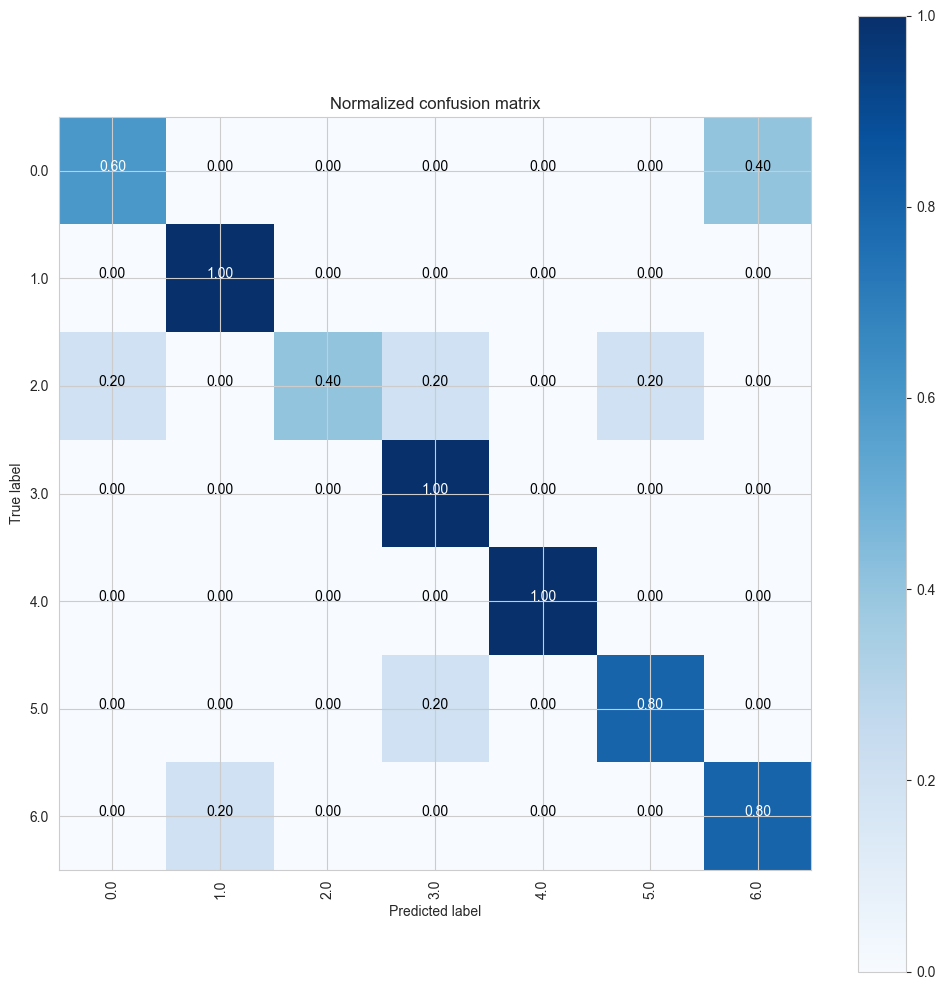

In [63]:
classes = list(map(str, list(np.unique(Y_test))))
cnf_matrix = metrics.confusion_matrix(Y_test, Y_pred)
np.set_printoptions(precision=2)

# Plot normalized confusion matrix
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cnf_matrix, classes=classes, normalize=True, title='Normalized confusion matrix')

plt.show()

In [17]:
tfjs.converters.save_keras_model(model1, "./modelo_reducido")

/Library/Frameworks/Python.framework/Versions/3.10/lib/python3.10/site-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
